# Image Regression

## MVA - Centrale Paris

In [1]:
import matplotlib.pyplot as plt
# %matplotlib inline
import numpy as np

from keras.utils import np_utils
from keras import optimizers

from generate_data import *

IMAGE_SIZE = 72

Using TensorFlow backend.


Generate training data and visualize a sample

Creating data:
0 / 500
100 / 500
200 / 500
300 / 500
400 / 500
500 / 500


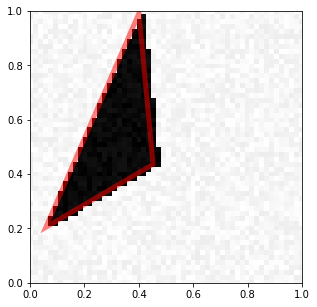

In [19]:
# Generate training set
[X_train, Y_train] = generate_dataset_regression(500, 20)
teacher.visualize_prediction(X_train[0], Y_train[0])

Reformating the input X

In [20]:
X_train = X_train.reshape(X_train.shape[0], 72, 72, 1)
print("X_train shape:", X_train.shape)

X_train shape: (500, 72, 72, 1)


Useful function to normalize the input Y:
It get easier to predict a triangle's corners when the model is trained on ordered corners (based on position y or x of the three corners)

In [21]:
# Reformating the input Y
print("Original   Y:", Y_train[0])

def normalize_triangle_y(Y_train):
    """Input: [x1, y1, x2, y2, x3, y3]
    Order the input from the highest y to the lowest
    ex: y2 > y3 > y1
    Output: [x2, y2, x3, y3, x1, y1]"""
    for i, train in enumerate(Y_train):
        dict_coord = {train[1]: train[0],
                     train[3]: train[2],
                     train[5]: train[4]}
        y_coord = [train[1], train[3], train[5]]
        y_coord.sort()
        list_final = []
        for y in y_coord:
            list_final.append(dict_coord[y])
            list_final.append(y)
        Y_train[i] = list_final
    return Y_train

Y_train = normalize_triangle_y(Y_train)
print("Normalized Y:", Y_train[0])

Original   Y: [0.45256219 0.43594428 0.40040836 0.99131074 0.05798788 0.2044488 ]
Normalized Y: [0.05798788 0.2044488  0.45256219 0.43594428 0.40040836 0.99131074]


In [22]:
from keras.layers import Dropout
# Regressor model
model_reg = Sequential()
model_reg.add(Conv2D(32, (3, 3), activation='relu'))
model_reg.add(MaxPooling2D(pool_size=(2, 2)))

model_reg.add(Conv2D(64, (3, 3), activation='relu'))
model_reg.add(MaxPooling2D(pool_size=(2, 2)))

model_reg.add(Conv2D(128, (3, 3), activation='relu'))
model_reg.add(MaxPooling2D(pool_size=(2, 2)))

model_reg.add(Flatten())

model_reg.add(Dense(128, activation='relu'))
model_reg.add(Dropout(0.3))
model_reg.add(Dense(128, activation='relu'))

model_reg.add(Dense(6, activation = 'linear'))

model_reg.compile(loss='mean_squared_error', optimizer='adam')

model_reg.fit(X_train, Y_train, batch_size=32, epochs=20, validation_split=0.4)

Train on 300 samples, validate on 200 samples
Epoch 1/20
300/300 [==============================] - 16s 52ms/step - loss: 0.1527 - val_loss: 0.0595
Epoch 2/20
300/300 [==============================] - 17s 57ms/step - loss: 0.0859 - val_loss: 0.0701
Epoch 3/20
300/300 [==============================] - 16s 54ms/step - loss: 0.0740 - val_loss: 0.0551
Epoch 4/20
300/300 [==============================] - 14s 46ms/step - loss: 0.0568 - val_loss: 0.0381
Epoch 5/20
300/300 [==============================] - 14s 47ms/step - loss: 0.0488 - val_loss: 0.0347
Epoch 6/20
300/300 [==============================] - 14s 48ms/step - loss: 0.0423 - val_loss: 0.0331
Epoch 7/20
300/300 [==============================] - 16s 53ms/step - loss: 0.0390 - val_loss: 0.0342
Epoch 8/20
300/300 [==============================] - 16s 52ms/step - loss: 0.0353 - val_loss: 0.0294
Epoch 9/20
300/300 [==============================] - 16s 52ms/step - loss: 0.0353 - val_loss: 0.0310
Epoch 10/20
300/300 [===============

In [23]:
# Generate test set
[X_test, Y_test] = teacher.generate_test_set_regression()
# Reshape X and normalize Y
[X_test, Y_test] = [X_test.reshape(X_test.shape[0], 72, 72, 1), normalize_triangle_y(Y_test)]

Creating data:
0 / 300
100 / 300
200 / 300
300 / 300


In [75]:
# Evaluate the model
model_reg.evaluate(X_test, Y_test)

300/300 [==============================] - 3s 9ms/step


0.016752328835427762

(72, 72, 1)


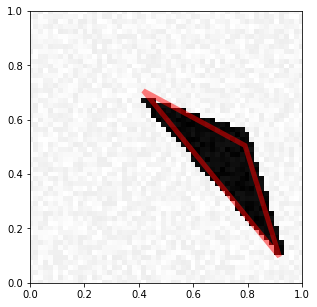

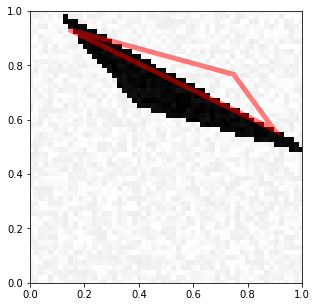

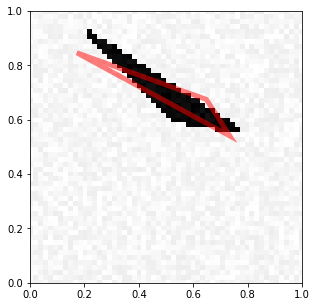

In [81]:
y_predict_reg = model_reg.predict(X_test)
print(X_test[0].shape)
for i in range(5, 8):
    teacher.visualize_prediction(X_test[i], y_predict_reg[i])

## 7. Image Denoising

### New functions to generate pairs of images

In [27]:
def generate_pair_triangles(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata_noise = teacher.generate_a_drawing(figsize, U, V, noise)
    imdata_noise_free = teacher.generate_a_drawing(figsize, U, V, 0)
    return [[imdata_noise, imdata_noise_free], [U[0], V[0], U[1], V[1], U[2], V[2]]]


def generate_pair_disks(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return [teacher.generate_a_drawing(figsize, U, V, noise), teacher.generate_a_drawing(figsize, U, V, 0)]


def generate_pair_rectangles(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return [teacher.generate_a_drawing(figsize, U, V, noise), teacher.generate_a_drawing(figsize, U, V, 0)]


def generate_dataset_classification_by_pairs(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = teacher.generate_a_rectangle().shape[0]
    X_noise = np.zeros([nb_samples,im_size])
    X_noise_free = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        noise_i = np.random.randint(255)
        if i % 100 == 0:
            print(i, "/", nb_samples)
        category = np.random.randint(3)
        if category == 0:
            [X_noise[i], X_noise_free[i]] = generate_pair_rectangles(noise_i, free_location)
        elif category == 1: 
            [X_noise[i], X_noise_free[i]] = generate_pair_disks(noise_i, free_location)
        else:	
            [X_noise[i], X_noise_free[i]] = generate_pair_triangles(noise_i, free_location)[0]
        X_noise[i] = (X_noise[i] + noise_i) / (255 + 2 * noise_i)
        X_noise_free[i] = X_noise_free[i] / 255
    print(nb_samples, "/", nb_samples)
    return [X_noise, X_noise_free]


def generate_test_set_classification_by_pairs():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification_by_pairs(300, 20, True)
    return [X_test, Y_test]

### Useful function to plot results

In [25]:
def denoise_plot(nb_samples, x, y, y_predict):
    plt.figure(figsize=(10,10))
    for i in range(nb_samples):
        for k in range(1, 4):
            plt.subplot(nb_samples, 3, 3 * i + k)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            if k == 1:
                plt.imshow(x[i].reshape(72,72), cmap= 'gray')
                plt.xlabel('Noised image')
            elif k == 2:
                plt.imshow(y[i].reshape(72,72), cmap= 'gray')
                plt.xlabel('Expected denoised image')
            elif k == 3:
                plt.imshow(y_predict[i].reshape(72,72), cmap= 'gray')
                plt.xlabel('Predicted denoised image')

In [28]:
# Generate data train 
X_noised_train, Y_denoised_train = generate_dataset_classification_by_pairs(600, 50, True)

Creating data:
0 / 600
100 / 600
200 / 600
300 / 600
400 / 600
500 / 600
600 / 600


In [29]:
# Reshape X_train_noise
X_noised_train = X_noised_train.reshape((X_noised_train.shape[0], 72, 72, 1))
Y_denoised_train = Y_denoised_train.reshape((Y_denoised_train.shape[0], 72, 72, 1))

print('X_noised_train shape  :', X_noised_train.shape)
print('Y_denoised_train shape:', Y_denoised_train.shape)

X_noised_train shape  : (600, 72, 72, 1)
Y_denoised_train shape: (600, 72, 72, 1)


Visualize the training sets

Text(0.5,1,'Denoised image generated')

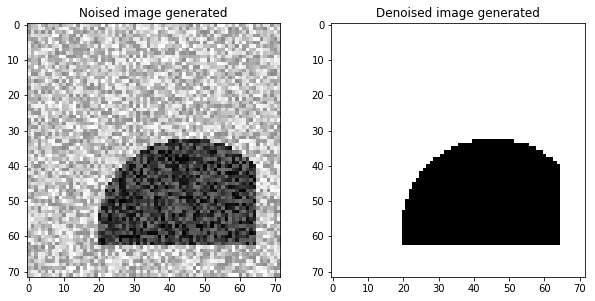

In [30]:
f, axes = plt.subplots(1, 2, figsize=(10, 10))

axes[0].imshow(X_noised_train[2].reshape(72, 72), cmap= 'gray')
axes[0].set_title('Noised image generated')
    
axes[1].imshow(Y_denoised_train[2].reshape(72, 72), cmap= 'gray')
axes[1].set_title('Denoised image generated')

### Denoising model

In [31]:
from keras.layers import advanced_activations, UpSampling2D

model_denoise = Sequential()

model_denoise.add(Conv2D(32, kernel_size=(3,3),activation='linear',input_shape=(72,72,1), padding='same'))
model_denoise.add(advanced_activations.LeakyReLU(alpha=0.1))
print(model_denoise.output_shape)

model_denoise.add(MaxPooling2D(pool_size=(2, 2)))
print(model_denoise.output_shape)

model_denoise.add(Conv2D(64, kernel_size=(3,3),activation='linear', padding='same'))
model_denoise.add(advanced_activations.LeakyReLU(alpha=0.1))
print(model_denoise.output_shape)

model_denoise.add(MaxPooling2D(pool_size=(2, 2)))
print(model_denoise.output_shape)

model_denoise.add(Conv2D(32, kernel_size=(3,3),activation='linear', padding='same'))
model_denoise.add(advanced_activations.LeakyReLU(alpha=0.1))
print(model_denoise.output_shape)

model_denoise.add(UpSampling2D(size=(2, 2)))
print(model_denoise.output_shape)

model_denoise.add(Conv2D(32, kernel_size=(3,3),activation='linear', padding='same'))
model_denoise.add(UpSampling2D(size=(2, 2)))
model_denoise.add(advanced_activations.LeakyReLU(alpha=0.1))
print(model_denoise.output_shape)

model_denoise.add(Conv2D(1, kernel_size=(3,3),activation='sigmoid', padding='same'))

model_denoise.compile(loss='mean_squared_error', optimizer = 'adam' ,metrics=['accuracy'])

model_denoise.fit(X_noised_train, Y_denoised_train, batch_size = 20, epochs= 20, validation_split = 0.4)

(None, 72, 72, 32)
(None, 36, 36, 32)
(None, 36, 36, 64)
(None, 18, 18, 64)
(None, 18, 18, 32)
(None, 36, 36, 32)
(None, 72, 72, 32)
Train on 360 samples, validate on 240 samples
Epoch 1/20
360/360 [==============================] - 34s 95ms/step - loss: 0.1109 - acc: 0.9008 - val_loss: 0.0892 - val_acc: 0.9080
Epoch 2/20
360/360 [==============================] - 35s 96ms/step - loss: 0.0791 - acc: 0.9091 - val_loss: 0.0688 - val_acc: 0.9114
Epoch 3/20
360/360 [==============================] - 37s 103ms/step - loss: 0.0351 - acc: 0.9607 - val_loss: 0.0103 - val_acc: 0.9889
Epoch 4/20
360/360 [==============================] - 35s 97ms/step - loss: 0.0105 - acc: 0.9858 - val_loss: 0.0097 - val_acc: 0.9868
Epoch 5/20
360/360 [==============================] - 34s 95ms/step - loss: 0.0073 - acc: 0.9904 - val_loss: 0.0062 - val_acc: 0.9922
Epoch 6/20
360/360 [==============================] - 34s 96ms/step - loss: 0.0063 - acc: 0.9918 - val_loss: 0.0058 - val_acc: 0.9928
Epoch 7/20
360/3

In [32]:
# Create test sets
[X_noised_test, Y_denoised_test] = generate_test_set_classification_by_pairs()
X_noised_test = X_noised_test.reshape(300, 72, 72, 1)
Y_predict_denoised = model_denoise.predict(X_noised_test)

Creating data:
0 / 300
100 / 300
200 / 300
300 / 300


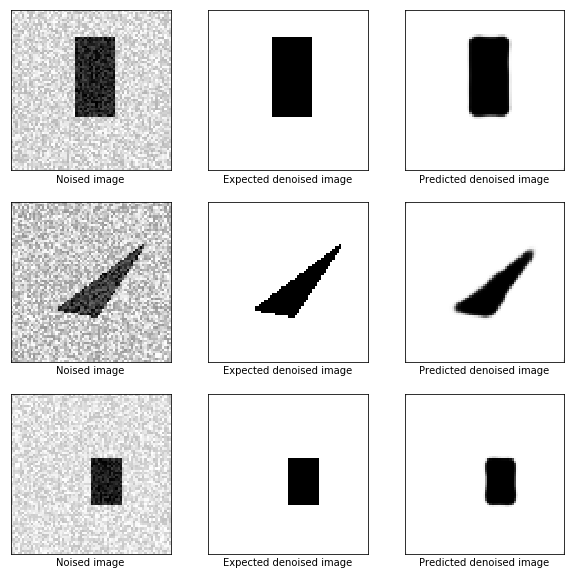

In [35]:
# Check the model
denoise_plot(3, X_noised_test, Y_denoised_test, Y_predict_denoised)